This is loosely based on https://smorabit.github.io/tutorials/8_velocyto/

In [2]:
import scvelo as scv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import igraph as ig
import anndata
import os
from tqdm.notebook import tqdm

In [3]:
loom_dir = 'RNA_velocity/'
data_dir = 'exported_matrices/'

datasets = pd.read_csv("datasets.csv", index_col=None)

output_dir = 'plots/RNA_velocity/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

datasets = datasets[~datasets['study_id'].isin(['Ho2020M', 'Ho2020F'])]

community_palette_markers_M = {"C_1": "#F16745", "C_2": "#FFC65D", "C_3": "#7BC8A4", "n/a": "#D3D3D3"}
community_palette_markers_F = {"C_1": "#F11E4E", "C_2": "#5B2C6F", "C_3": "#1A9337", "C_4": "#4CC3D9", "n/a": "#D3D3D3"}
community_palette_lab_tr_M = {"C_1": "#7BC8A4", "C_2": "#F16745", "C_3": "#FFC65D", "C_4": "#C44A9A", "C_5": "#4A90F2", "n/a": "#D3D3D3"}
community_palette_lab_tr_F = {"C_1": "#F11E4E", "C_2": "#5B2C6F", "C_3": "#1A9337", "C_4": "#4CC3D9", "C_5": "#CDABFF", "n/a": "#D3D3D3"}

In [4]:
def convert_to_AnnData(dataset: str, verbose: bool = True) -> anndata.AnnData:
    """ 
    Loads the velocity data for a given dataset.

    Parameters
    ----------
    dataset : str
        The dataset to load.
    verbose : bool
        Whether to print out progress information, defaults to True.

    Returns
    -------
    adata : anndata.AnnData
        The AnnData object containing the expression and velocity data.    
    """

    # Start by merging the loom files
    filtered_datasets = datasets[datasets['study_id'] == dataset]
    loom_filenames = [f"{row['study_id']}_{row['source']}" for _,
                      row in filtered_datasets.iterrows()]

    # Read dataset information
    pca = pd.read_csv(f"{data_dir}/{dataset}_pca.csv", index_col=None)
    umap = pd.read_csv(f"{data_dir}/{dataset}_umap.csv", index_col=None)
    clusters = pd.read_csv(
        f"{data_dir}/{dataset}_clusters.csv", index_col=None)
    counts = pd.read_csv(
        f"{data_dir}{dataset}_counts.csv", index_col=0)
    metadata = pd.read_csv(f"{data_dir}{dataset}_metadata.csv", index_col=None)
    # Remove the -n from the barcode
    metadata['Barcode'] = [x[:-2] for x in metadata['Barcode']]
    gene_names = counts.index.values
    
    assert pca.shape[0] == umap.shape[0] == clusters.shape[0] == metadata.shape[0] == counts.shape[1]

    vel_data = None
    num_removed = 0

    for i, filename in enumerate(loom_filenames):
        if verbose:
            print(f"Loading {filename}.loom")
        if i == 0:
            vel_data = scv.read(f"{loom_dir}{filename}.loom", cache=False)
            scv.utils.clean_obs_names(
                vel_data, id_length=16, alphabet="[ACGT]", inplace=True)
            vel_data.var_names_make_unique()

            # Only select common genes
            vel_data = vel_data[:, gene_names]
        else:
            vel_data2 = scv.read(f"{loom_dir}{filename}.loom", cache=False)
            scv.utils.clean_obs_names(
                vel_data2, id_length=16, alphabet="[ACGT]", inplace=True)

            common_barcodes = np.intersect1d(
                vel_data.obs.index, vel_data2.obs.index)

            # Remove barcodes that are in both datasets from the second dataset, otherwise scv.utils.merge will fail
            # This is not perfect, but it's a very small number of barcodes
            vel_data2 = vel_data2[~vel_data2.obs.index.isin(common_barcodes)]
            num_removed += len(common_barcodes)

            vel_data2.var_names_make_unique()
            vel_data2 = vel_data2[:, gene_names]
            vel_data = vel_data.concatenate(vel_data2, index_unique=None)

    if verbose:
        print(f"Removed {num_removed} barcodes that were in multiple datasets")
        print(f"Final shape: {vel_data.shape}")

    # Add metadata and dimensionality reductions

    vel_barcodes = vel_data.obs.index
    vel_data.var.index = gene_names

    pca['Barcode'] = [x.split('-')[0] for x in pca['Barcode']]
    pca = pca.drop_duplicates(subset=['Barcode'])
    pca = pca[pca['Barcode'].isin(vel_barcodes)]
    pca = pca.set_index('Barcode', drop=True)
    pca = pca.reindex(vel_barcodes)

    umap['Barcode'] = [x.split('-')[0] for x in umap['Barcode']]
    umap = umap.drop_duplicates(subset=['Barcode'])
    umap = umap[umap['Barcode'].isin(vel_barcodes)]
    umap = umap.set_index('Barcode', drop=True)
    umap = umap.reindex(vel_barcodes)

    clusters['Barcode'] = [x.split('-')[0] for x in clusters['Barcode']]
    clusters = clusters.drop_duplicates(subset=['Barcode'])
    clusters = clusters[clusters['Barcode'].isin(vel_barcodes)]
    clusters = clusters.set_index('Barcode', drop=True)
    clusters = clusters.reindex(vel_barcodes)

    vel_data.obsm['X_pca'] = pca
    vel_data.obsm['X_umap'] = np.vstack(
        (umap['UMAP_1'].values, umap['UMAP_2'].values)).T
    vel_data.obs["cluster"] = [f"C{c}" for c in clusters['Cluster']]
    vel_data.obs["cluster"] = vel_data.obs["cluster"].astype("category")
    vel_data.obs["community_marker"] = [f"C_{int(c)}" if not np.isnan(
        c) else "n/a" for c in clusters['Community_markers_10']]
    vel_data.obs["community_marker"] = vel_data.obs["community_marker"].astype(
        "category")
    
    # Filter metadata by remaining barcodes
    metadata = metadata[metadata['Barcode'].isin(vel_barcodes)]
    # Reorder metadata by barcode so that it matches the order of the AnnData object
    metadata = metadata.set_index('Barcode', drop=True)
    metadata = metadata.reindex(vel_barcodes)    
    vel_data.obs["community_lab_tr"] = [f"C_{int(c)}" if not np.isnan(
        c) else "n/a" for c in metadata['nn_community_0.9']]
    vel_data.obs["community_lab_tr"] = vel_data.obs["community_lab_tr"].astype(
        "category")

    return vel_data


def process_velocity(dataset: str) -> anndata.AnnData:
    """
    Processes the velocity data for a given dataset.

    Parameters
    ----------
    dataset : str
        The dataset to process.

    Returns
    -------
    adata : anndata.AnnData
        The AnnData object containing the processed velocity data.
    """
    adata = convert_to_AnnData(dataset)

    print(f"Processing {dataset}")
    # Preprocessing steps
    scv.pp.filter_and_normalize(adata, enforce=True)
    scv.pp.moments(adata)

    # Dynamics recovery and velocity calculation
    scv.tl.recover_dynamics(adata, n_jobs=16)
    scv.tl.velocity(adata, mode='dynamical')
    scv.tl.velocity_graph(adata)

    # Ranking velocity genes (optional)
    scv.tl.rank_velocity_genes(adata, groupby="community_marker", min_corr=0.4)

    # Calculate velocity pseudotime
    scv.tl.velocity_pseudotime(adata)
    return adata

We perform velocity calculation for all datasets and put the results in the `vel_objects` dictionary so we can plot things later faster.

In [5]:
vel_objects = {}

for dataset in [d for d in datasets['study_id'].unique() if d not in ['Ho2020M', 'Ho2020F']]:
    vel_objects[dataset] = process_velocity(dataset)

Loading Ruf_Zamojski2021F_SRR11945353.loom
Loading Ruf_Zamojski2021F_SRR11945364.loom
Loading Ruf_Zamojski2021F_SRR11945365.loom
Loading Ruf_Zamojski2021F_SRR11945366.loom
Removed 1582 barcodes that were in multiple datasets
Final shape: (1584, 11103)
Processing Ruf_Zamojski2021F
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors


2025-01-31 08:54:05.050343: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-31 08:54:06.731312: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 16/16 cores)


  0%|          | 0/940 [00:00<?, ?gene/s]

    finished (0:00:16) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/1584 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:02) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Loading Ruf_Zamojski2021M_SRR11945354.loom
Loading Ruf_Zamojski2021M_SRR11945355.loom
Loading Ruf_Zamojski2021M_SRR11945356.loom
Loading Ruf_Zamojski2021M_SRR11945357.loom
Loading Ruf_Zamojski2021M_SRR11945358.loom
Loading Ruf_Zamojski2021M_SRR11945359.loom
Loading Ruf_Zamojski2021M_SRR11945360.loom
Loading Ruf_Zamojski2021M_SRR11945361.loom
Loading Ruf_Zamojski2021M_SRR11945362.loom
Loading Ruf_Zamojski2021M_SRR11945363.loom
Removed 1355 barcodes that were in multiple datasets
Final shape: (1360, 11103)
Processing Ruf_Zamojski2021M
Normalized count data: X, splice

  0%|          | 0/1239 [00:00<?, ?gene/s]

    finished (0:00:15) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/1360 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:03) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Loading Lopez2021M_SRR13081817.loom
Removed 0 barcodes that were in multiple datasets
Final shape: (354, 11103)
Processing Lopez2021M
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 16/16 cores)


  0%|          | 0/1157 [00:00<?, ?gene/s]

    finished (0:00:10) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/354 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Loading Allensworth2021F_SRR12074650.loom
Loading Allensworth2021F_SRR12074651.loom
Loading Allensworth2021F_SRR12074652.loom
Loading Allensworth2021F_SRR12074653.loom
Loading Allensworth2021F_SRR12074654.loom
Loading Allensworth2021F_SRR12074655.loom
Loading Allensworth2021F_SRR12074656.loom
Loading Allensworth2021F_SRR12074657.loom
Removed 939 barcodes that were in multiple datasets
Final shape: (313, 11103)
Processing Allensworth2021F
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distanc

  0%|          | 0/547 [00:00<?, ?gene/s]

    finished (0:00:06) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/313 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Loading Vennekens2021M_scrEXT036.loom
Loading Vennekens2021M_scrEXT149.loom
Removed 0 barcodes that were in multiple datasets
Final shape: (541, 11103)
Processing Vennekens2021M
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 16/16 cores)


  0%|          | 0/1069 [00:00<?, ?gene/s]

    finished (0:00:10) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/541 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Loading Mayran2019M_SRR8487461.loom
Removed 0 barcodes that were in multiple datasets
Final shape: (954, 11103)
Processing Mayran2019M
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 16/16 cores)


  0%|          | 0/1122 [00:00<?, ?gene/s]

    finished (0:00:11) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/954 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:02) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Loading Cheung2018M_SRR7898909.loom
Loading Cheung2018M_SRR7898910.loom
Removed 4 barcodes that were in multiple datasets
Final shape: (961, 11103)
Processing Cheung2018M
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 16/16 cores)


  0%|          | 0/898 [00:00<?, ?gene/s]

    finished (0:00:11) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/961 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:02) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
computing terminal states
    identified 3 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Loading Kucka2021F_SRR15926823.loom
Loading Kucka2021F_SRR15926823.loom
Loading Kucka2021F_SRR15926825.loom
Loading Kucka2021F_SRR15926825.loom
Loading Kucka2021F_SRR15926826.loom
Loading Kucka2021F_SRR15926826.loom
Removed 1232 barcodes that were in multiple datasets
Final shape: (1228, 11103)
Processing Kucka2021F
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (

  0%|          | 0/105 [00:00<?, ?gene/s]

    finished (0:00:05) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/1228 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:02) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Loading Fletcher2019F_SRR9203724.loom
Loading Fletcher2019F_SRR9203725.loom
Loading Fletcher2019F_SRR9203726.loom
Loading Fletcher2019F_SRR9203727.loom
Removed 391 barcodes that were in multiple datasets
Final shape: (391, 11103)
Processing Fletcher2019F
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abu

  0%|          | 0/39 [00:00<?, ?gene/s]

    finished (0:00:03) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/391 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
computing terminal states
    identified 3 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Loading Fletcher2019M_SRR9203728.loom
Loading Fletcher2019M_SRR9203729.loom
Loading Fletcher2019M_SRR9203730.loom
Loading Fletcher2019M_SRR9203731.loom
Removed 548 barcodes that were in multiple datasets
Final shape: (548, 11103)
Processing Fletcher2019M
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced ab

  0%|          | 0/45 [00:00<?, ?gene/s]

    finished (0:00:03) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/548 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
ranking velocity genes


/home/nico/Storage/single_cell_env/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:01) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


Transitions for communmities calculated either with markers or label transfer

In [6]:
def do_velocity_plot(dataset: str, type: str = "stream", color_by: str = "markers", do_save: bool = True):
    """
    Plots the RNA velocity for a given dataset.

    Parameters
    ----------
    dataset : str
        The dataset to plot.        
    type : str
        The type of plot to generate, one of "stream" (default, stream plot) or "pseudotime" (pseudotime plotted on UMAP) or "pseudotime_vln" (summary violin plot of pseudotime)
    color_by : str
        The variable to color by, defaults to "markers". Possible values are "markers" or "nn", using the communities identified by the markers or through label transfer.
    do_save : bool
        Whether to save the plot to a file, defaults to True.
    """
    assert (type in ["stream", "pseudotime", "pseudotime_vln"])
    assert (color_by in ["markers", "nn"])

    adata = vel_objects[dataset]

    # We want the palette to match what we got from R
    if color_by == "markers":
        communities = list(adata.obs['community_marker'].cat.categories)        
        if dataset.endswith("M"):
            community_palette = community_palette_markers_M
        elif dataset.endswith("F"):
            community_palette = community_palette_markers_F
    else:
        communities = list(adata.obs['community_lab_tr'].cat.categories)
        if dataset.endswith("M"):
            community_palette = community_palette_lab_tr_M
        elif dataset.endswith("F"):
            community_palette = community_palette_lab_tr_F
        
    if type == "stream":
        if do_save:
            outfile = f"{output_dir}{dataset}_velocity_umap_{type}_comm_{color_by}.svg"
        else:
            outfile = None

        _, ax = plt.subplots(figsize=(5, 8))

        scv.pl.velocity_embedding_stream(adata, basis='umap', color=['community_marker' if color_by == "markers" else 'community_lab_tr'],
                                         palette=[community_palette[c]
                                                  for c in communities],
                                         alpha=1,
                                         size=150, title=f"RNA velocity - {dataset}", ax=ax,
                                         show=True, save=outfile)
        plt.show()
    elif type == "pseudotime":
        if do_save:
            outfile = f"{output_dir}{dataset}_pseudotime_umap_{type}.pdf"
        else:
            outfile = None

        _, ax = plt.subplots(figsize=(5, 8))

        scv.pl.scatter(adata, basis='umap', color='velocity_pseudotime',
                       title=f"RNA velocity pseudotime - {dataset}",
                       save=outfile, ax=ax)
        plt.show()
    elif type == "pseudotime_vln":
        if do_save:
            outfile = f"{output_dir}{dataset}_pseudotime_violin_comm_{color_by}.pdf"
        else:
            outfile = None        

        # Plot a violin plot of the pseudotime, ordered by median, to simplify ordering of the communities
        if color_by == "markers":
            ordered_categories = adata.obs.groupby('community_marker')['velocity_pseudotime'].median().sort_values().index
        else:
            ordered_categories = adata.obs.groupby('community_lab_tr')['velocity_pseudotime'].median().sort_values().index

        _, ax = plt.subplots(figsize=(3, 5))

        sns.violinplot(x=adata.obs['community_marker' if color_by == "markers" else 'community_lab_tr'], 
                    y=adata.obs['velocity_pseudotime'], color='white', inner = None, 
                    order=ordered_categories, ax=ax)
        
        plt.xlabel("Community")
        plt.ylabel("Pseudotime")
        plt.title(f"RNA velocity pseudotime - {dataset}")
        if do_save:
            plt.savefig(outfile)
            plt.show()


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file plots/RNA_velocity/Ruf_Zamojski2021F_velocity_umap_stream_comm_markers.svg


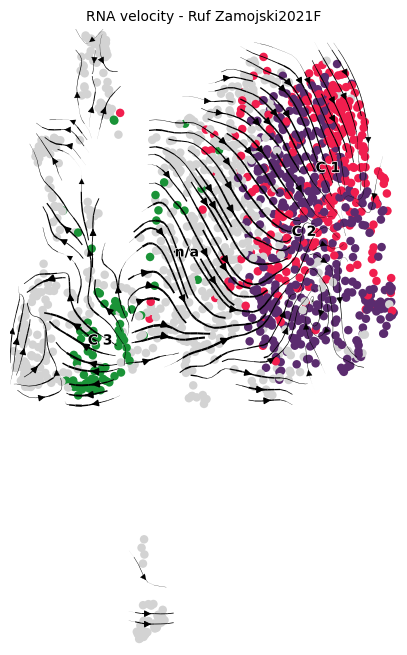

saving figure to file plots/RNA_velocity/Ruf_Zamojski2021F_velocity_umap_stream_comm_nn.svg


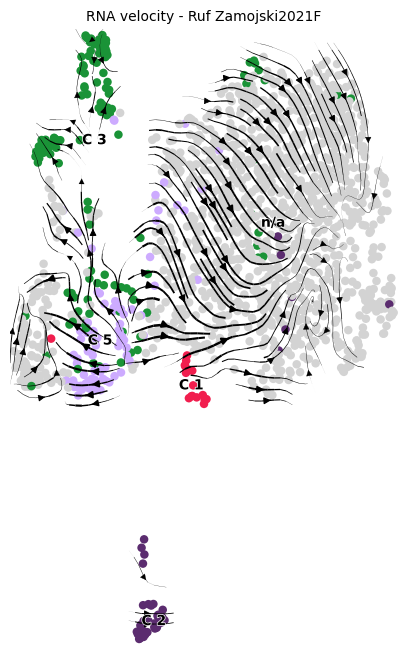

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file plots/RNA_velocity/Ruf_Zamojski2021M_velocity_umap_stream_comm_markers.svg


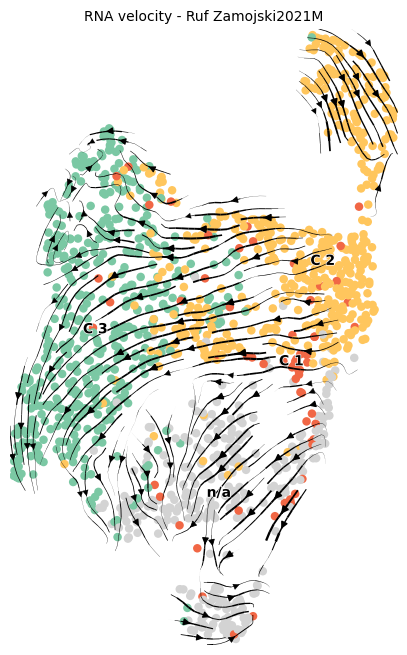

saving figure to file plots/RNA_velocity/Ruf_Zamojski2021M_velocity_umap_stream_comm_nn.svg


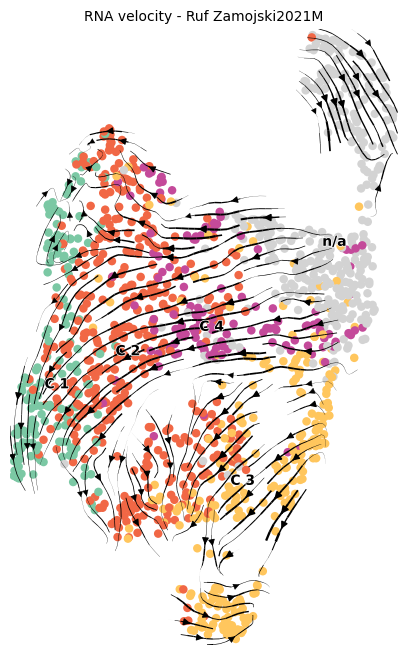

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file plots/RNA_velocity/Lopez2021M_velocity_umap_stream_comm_markers.svg


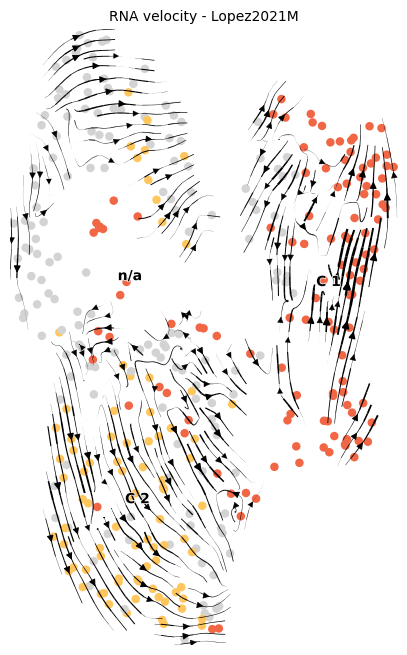

saving figure to file plots/RNA_velocity/Lopez2021M_velocity_umap_stream_comm_nn.svg


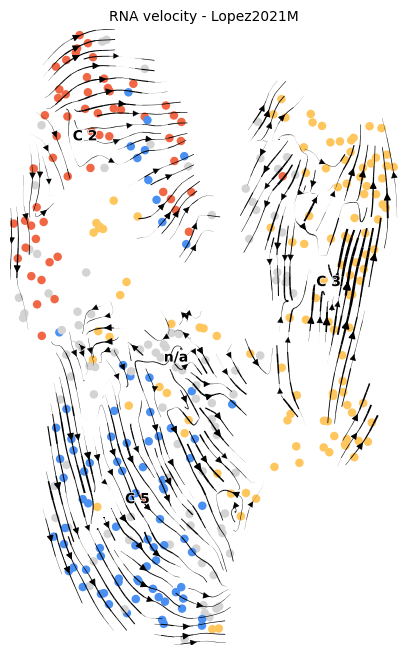

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file plots/RNA_velocity/Allensworth2021F_velocity_umap_stream_comm_markers.svg


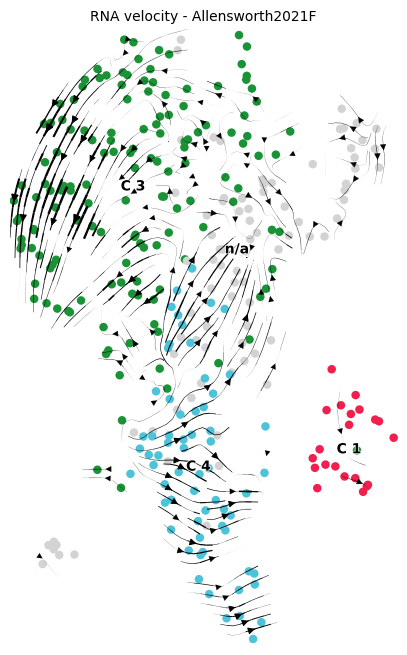

saving figure to file plots/RNA_velocity/Allensworth2021F_velocity_umap_stream_comm_nn.svg


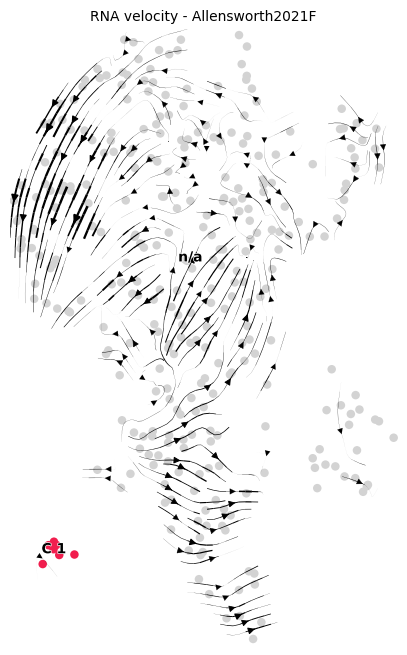

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file plots/RNA_velocity/Vennekens2021M_velocity_umap_stream_comm_markers.svg


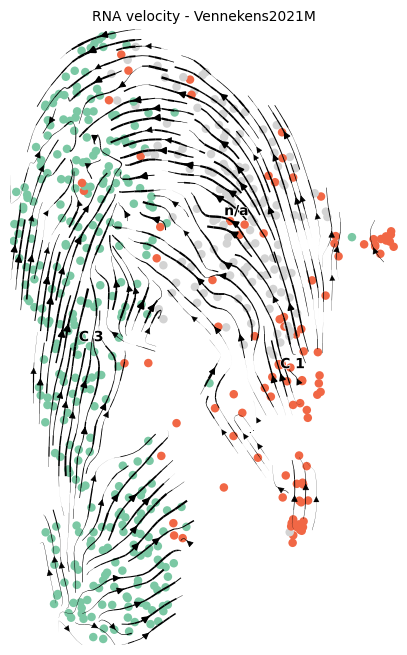

saving figure to file plots/RNA_velocity/Vennekens2021M_velocity_umap_stream_comm_nn.svg


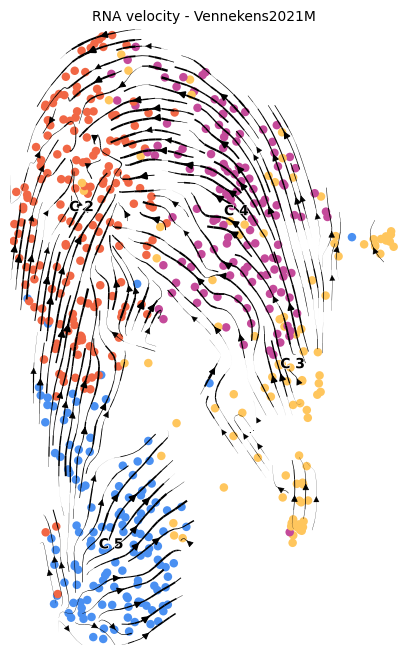

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file plots/RNA_velocity/Mayran2019M_velocity_umap_stream_comm_markers.svg


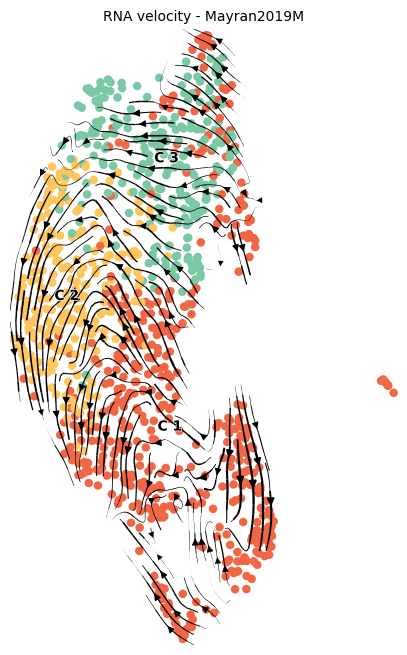

saving figure to file plots/RNA_velocity/Mayran2019M_velocity_umap_stream_comm_nn.svg


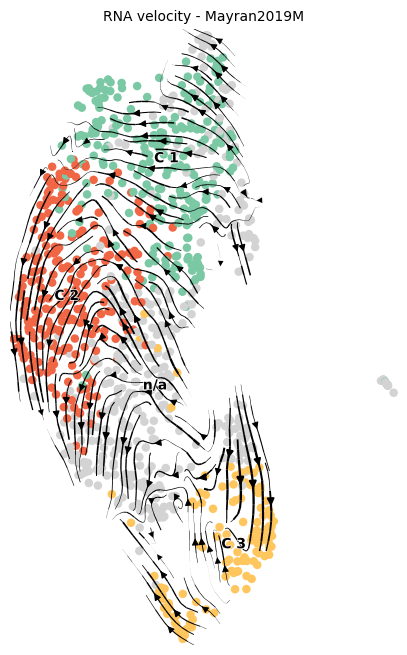

saving figure to file plots/RNA_velocity/Cheung2018M_velocity_umap_stream_comm_markers.svg


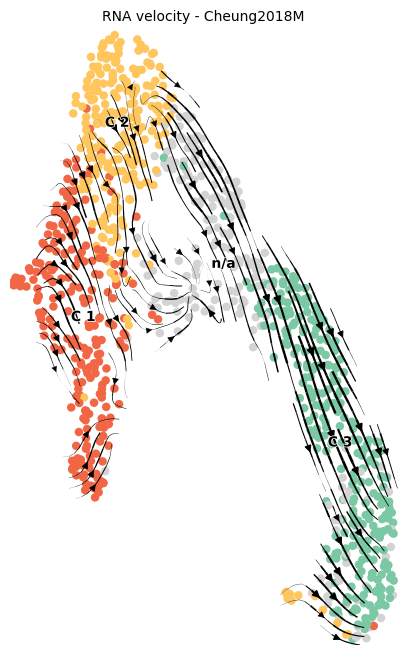

saving figure to file plots/RNA_velocity/Cheung2018M_velocity_umap_stream_comm_nn.svg


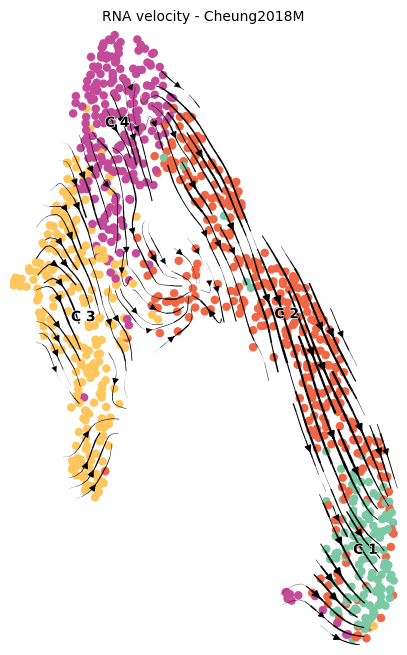

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file plots/RNA_velocity/Kucka2021F_velocity_umap_stream_comm_markers.svg


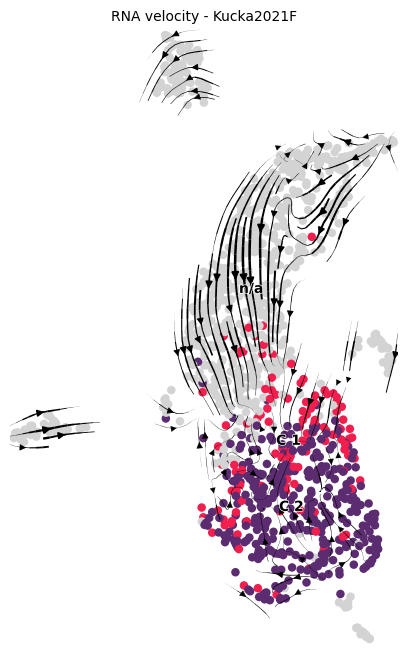

saving figure to file plots/RNA_velocity/Kucka2021F_velocity_umap_stream_comm_nn.svg


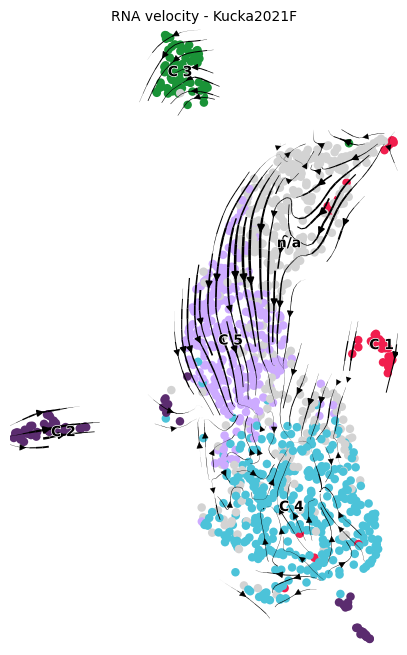

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file plots/RNA_velocity/Fletcher2019F_velocity_umap_stream_comm_markers.svg


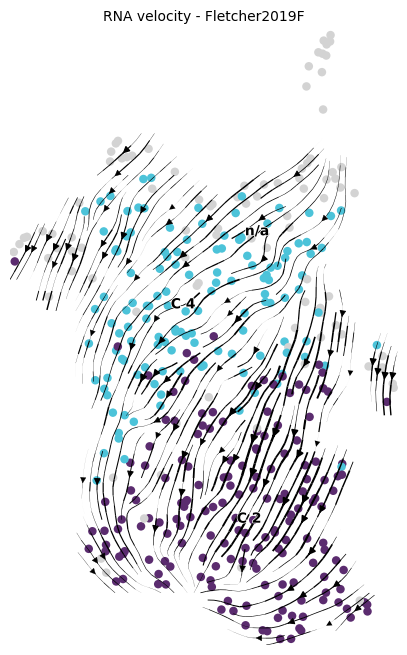

saving figure to file plots/RNA_velocity/Fletcher2019F_velocity_umap_stream_comm_nn.svg


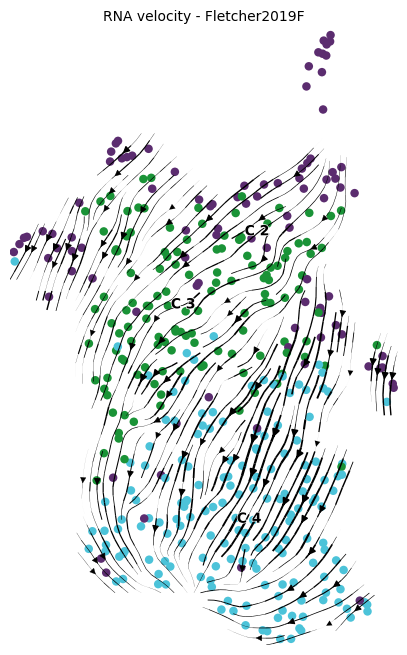

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file plots/RNA_velocity/Fletcher2019M_velocity_umap_stream_comm_markers.svg


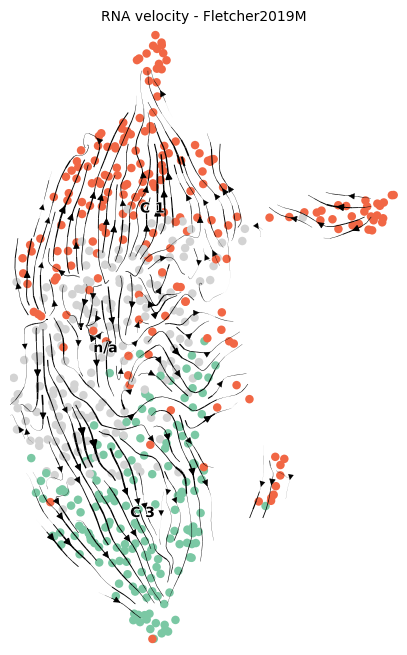

saving figure to file plots/RNA_velocity/Fletcher2019M_velocity_umap_stream_comm_nn.svg


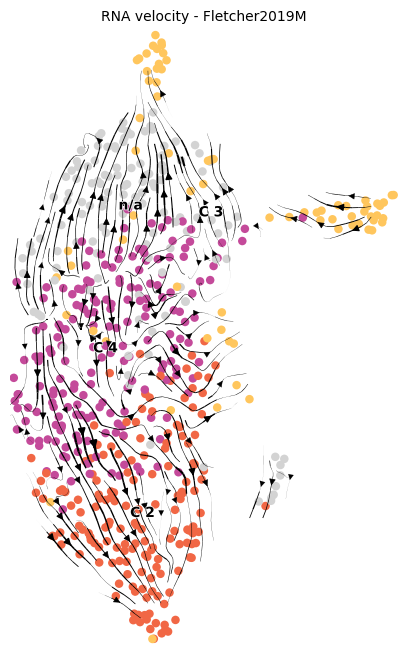

In [32]:
for d in datasets['study_id'].unique():
    do_velocity_plot(d, type="stream", color_by="markers", do_save=True)
    do_velocity_plot(d, type="stream", color_by="nn", do_save=True)

In [40]:

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    """
    Calculates the cosine similarity between two vectors
    """
    
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def create_graph(transition_matrix: np.ndarray, communities: list, do_plot: bool = True, palette: dict = community_palette_markers_M, outfile = None) -> ig.Graph:
    """
    Creates a directed graph based on the transition matrix between communities.
    
    Parameters
    ----------
    transition_matrix : np.ndarray
        The transition matrix between the communities, calculated using get_transition_matrix.
    communities : list
        The list of communities.
    do_plot : bool
        Whether to plot the graph, defaults to True.
    palette : dict
        The color palette to use for the communities.
    outfile : str
        The output file to save the plot to, defaults to None.
        
    Returns
    -------
    G : igraph.Graph
        The directed graph representing the transition matrix.
    """
        
    # Initialize an empty directed graph
    G = ig.Graph(directed=True)

    # Add vertices (clusters/communities)
    G.add_vertices(communities)

    # Add edges based on the transition matrix
    for i, c1 in enumerate(communities):
        for j, c2 in enumerate(communities):
            if transition_matrix[i, j] > 0:
                G.add_edge(c1, c2, weight=transition_matrix[i, j])
    
    layout = G.layout("fr")

    if do_plot:
        _, ax = plt.subplots(figsize=(8, 6))

        visual_style = {
                "vertex_size": 40,
                "vertex_color": [palette[c] for c in communities],
                "vertex_label": G.vs["name"],
                "vertex_label_size": 12
        }

        if len(G.es) > 0:
            max_w = max(G.es["weight"])
            gray_shade = [int(255 * (1 - w / max_w)) for w in G.es["weight"]]
            print(gray_shade)
            visual_style.update({
                # Make shades of gray for the edges depending on the weight
                "edge_color": [f"#{g:X}{g:X}{g:X}" for g in gray_shade],
                # Weight of edge and transparency are proportional to the transition probability
                "edge_width": [np.log(weight + 1) * 6 for weight in G.es["weight"]],
                "edge_opacity": [0.6 * weight for weight in G.es["weight"]],
                "edge_curved": 0.2
            })
        ig.plot(G, layout=layout, **visual_style, target=ax)
        
        if outfile:
            plt.savefig(outfile)

        plt.show()

def calculate_transitions(dataset: str, comm_by: str = "markers", do_plots = False) -> tuple[np.ndarray, list, ig.Graph]:
    """
    Calculates the transition matrix for the communities in a dataset, 
    based on the weighted cosine similarity between the mean velocity vector and 
    the vector between the cluster centroids, then generates a directed graph.
    
    Parameters
    ----------
    dataset : str
        The dataset to calculate the transition matrix for.
        
    comm_by : str
        The variable that defines the clusters, defaults to "markers". Can be "markers" or "nn".        
        
    do_plots : bool
        Whether to plot the cluster centroids and the mean velocity vectors, as well as the matrix defaults to False.
        
    Returns
    -------
    (transition_matrix, communities, graph) : tuple
        transition_matrix : np.ndarray
            The transition matrix between the communities.
        communities : list
            The list of community names.
        graph : igraph.Graph
            The directed graph representing the transition matrix.
    """
    
    assert comm_by in ["markers", "nn"]
    
    adata = vel_objects[dataset]
    if comm_by == "markers":
        communities = adata.obs['community_marker'].unique()
        comm_values = adata.obs['community_marker']
    else:
        communities = adata.obs['community_lab_tr'].unique()
        comm_values = adata.obs['community_lab_tr']

    comm_velocities = {c: adata[comm_values == c].obsm['velocity_umap'].mean(axis=0)
                    for c in communities}

    comm_velocities = {c: np.array(v) for c, v in comm_velocities.items()}

    if comm_by == "markers":
        if dataset.endswith("M"):
            community_palette = community_palette_markers_M
        else:
            community_palette = community_palette_markers_F
    else:
        if dataset.endswith("M"):
            community_palette = community_palette_lab_tr_M
        else:
            community_palette = community_palette_lab_tr_F    

    if do_plots:                    
        # Draw the cluster means as arrows
        plt.figure(figsize=(4, 5))
        plt.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1],
                    c=[community_palette[c] for c in comm_values], s=10)
        scale_factor = 10
        for c, mean in comm_velocities.items():
            # cluster centroid
            centroid = adata[comm_values == c].obsm['X_umap'].mean(axis=0)
            plt.arrow(centroid[0], centroid[1], mean[0]*scale_factor, mean[1]
                    * scale_factor, head_width=.2, head_length=.4, fc='k', ec='k')
            plt.text(centroid[0], centroid[1], c, fontsize=12)
            
        plt.show()

    cluster_centroids = {c: adata[comm_values == c].obsm['X_umap'].mean(axis=0)
                            for c in communities}

    transition_matrix = np.zeros((len(communities), len(communities)))

    for i, c1 in enumerate(communities):
        for j, c2 in enumerate(communities):
            if i != j:
                # Calculate the cosine similarity between the mean velocity vector and the vector between the cluster centroids
                displacement = cluster_centroids[c2] - cluster_centroids[c1]
                projection = cosine_similarity(comm_velocities[c1], displacement)
                
                # Only consider transitions with positive projection and an angle less than ~40 degrees (cos(theta) = 0.75)
                if projection > 0.75:  
                    transition_matrix[i, j] = projection
                else:
                    transition_matrix[i, j] = 0
                    
                # Now weight the transition by the magnitude of the velocity vector
                transition_matrix[i, j] *= np.linalg.norm(comm_velocities[c1])

    # Normalise the transition matrix
    transition_matrix = transition_matrix / transition_matrix.sum(axis=1)[:, None]
    # Replace NaNs with zeros (this also would replace inf values with big numbers, but it doesn't happen here)
    transition_matrix = np.nan_to_num(transition_matrix)
    
    if do_plots:
        plt.figure(figsize=(5, 5))
        sns.heatmap(transition_matrix, annot=True, 
                    xticklabels=communities, yticklabels=communities,
                    cmap='viridis', cbar_kws={'label': 'Transition probability'})
        plt.xlabel("To")
        plt.ylabel("From")
        plt.title(f"Transition matrix - {dataset}")
        plt.show()
        
    graph = create_graph(transition_matrix, communities, do_plots, palette = community_palette)
    
    return transition_matrix, communities, graph

Now we calculate the transition matrices for the communities using the velocity results, which are used to calculate the transition probabilities between communities.

We then combine the transition probabilities from the various datasets as a weighted average, where the weights are the number of cells in each dataset.

Finally, we create a graph of the transition probabilities between the communities.

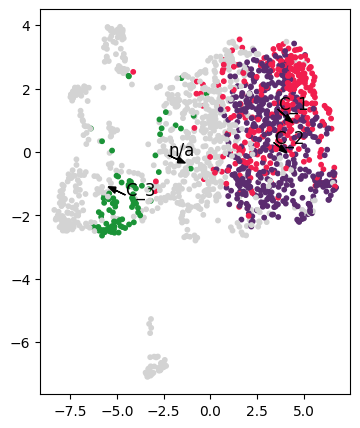

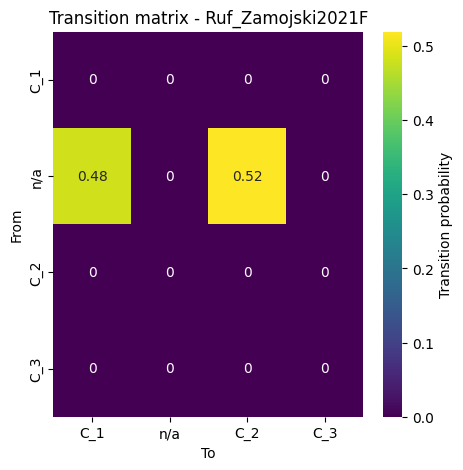

[18, 0]


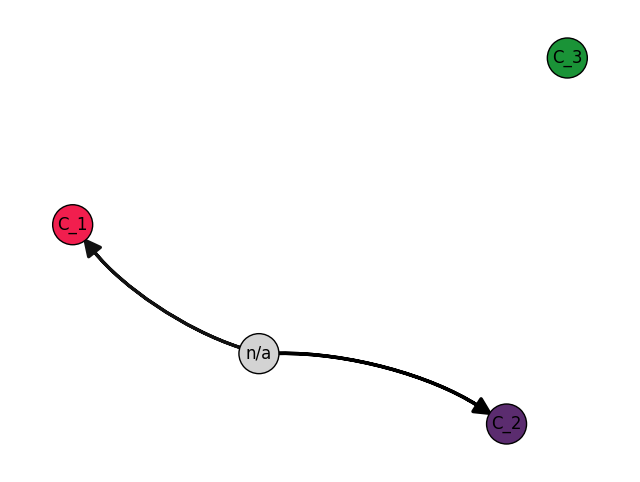

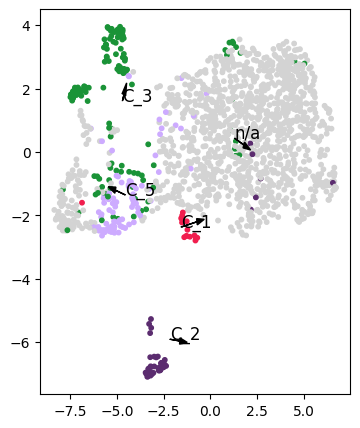

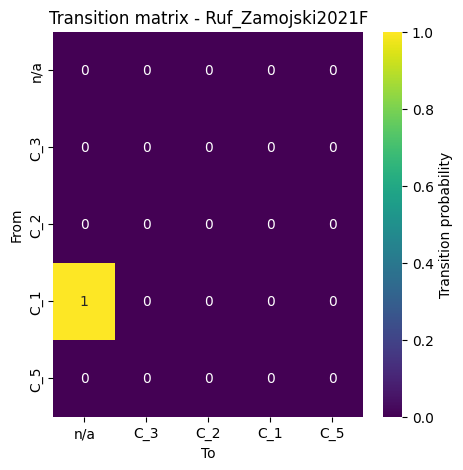

[0]


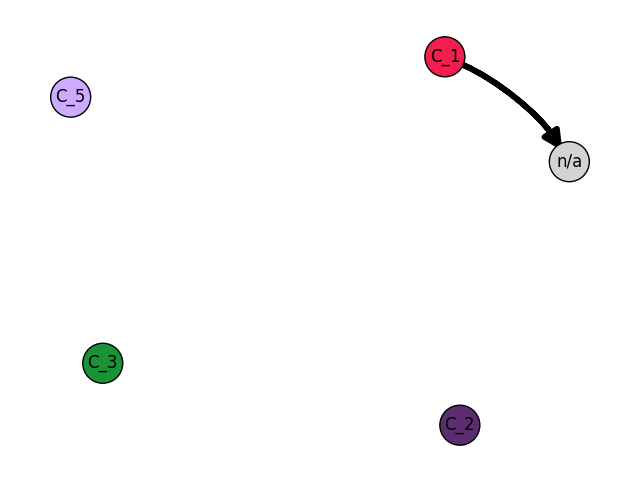

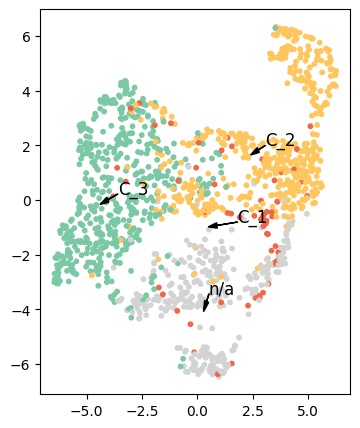

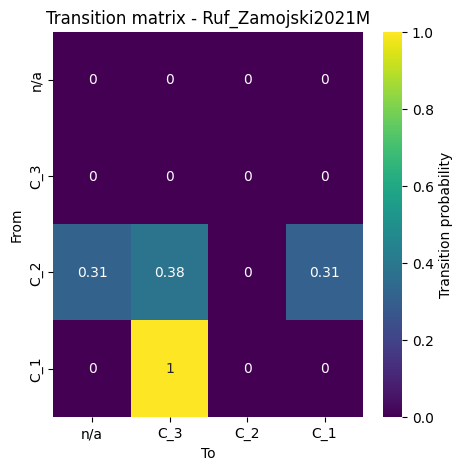

[175, 157, 176, 0]


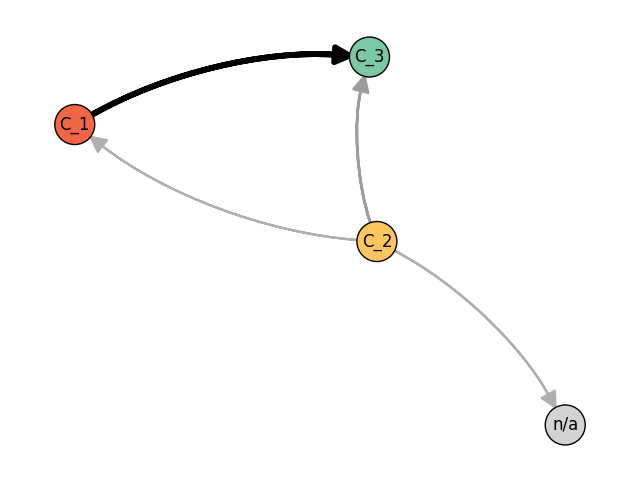

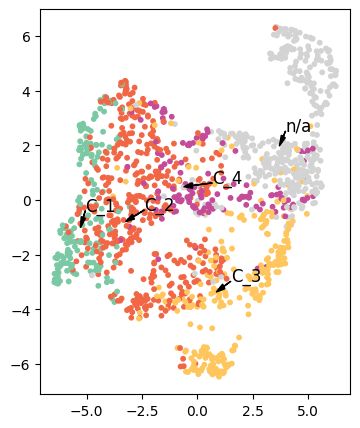

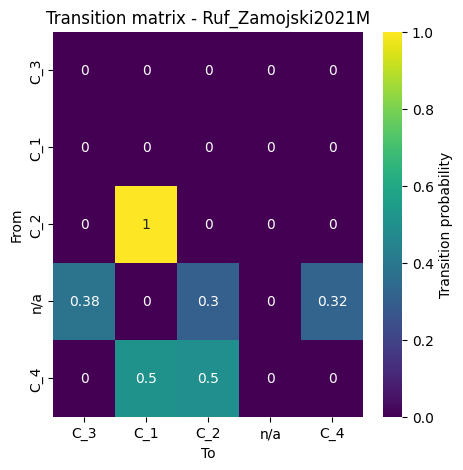

[0, 157, 178, 173, 126, 128]


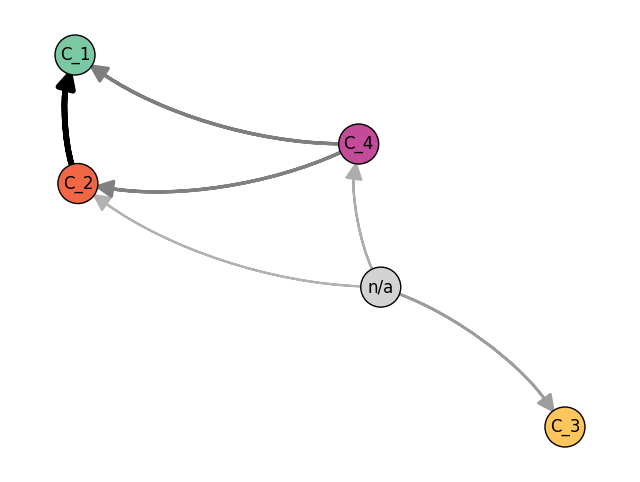

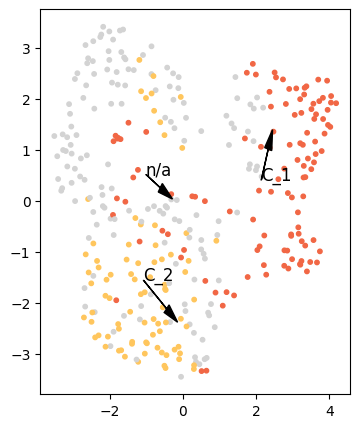

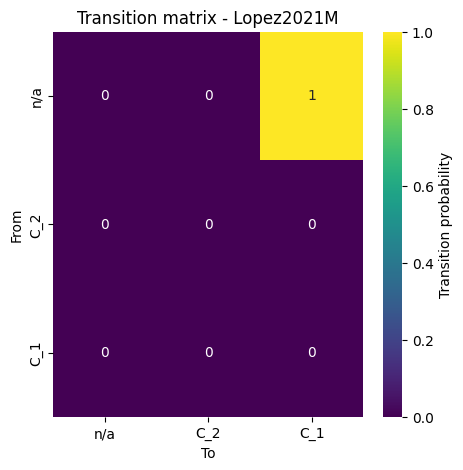

[0]


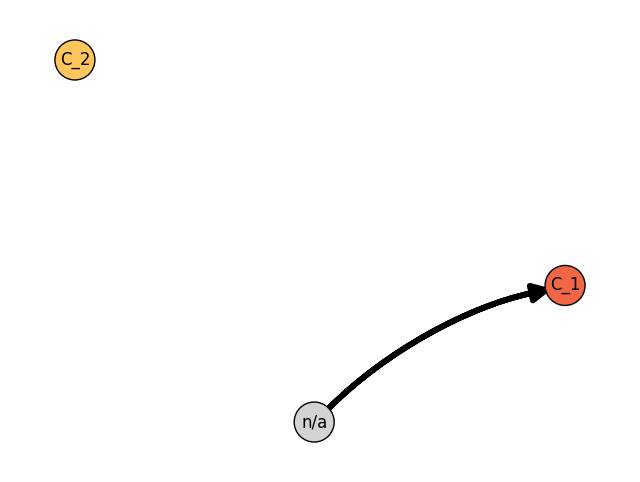

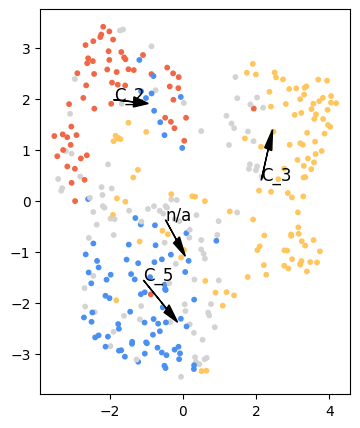

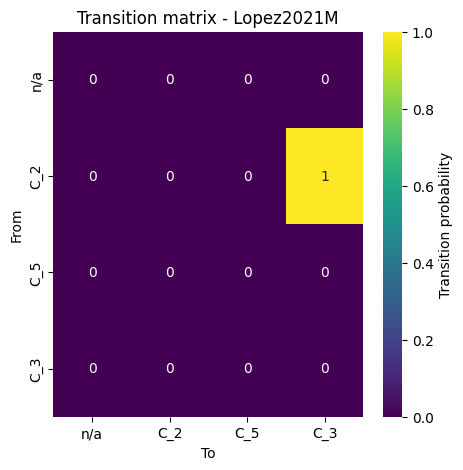

[0]


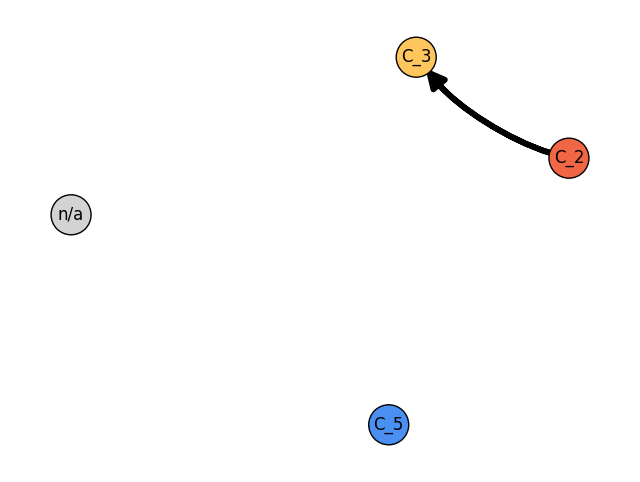

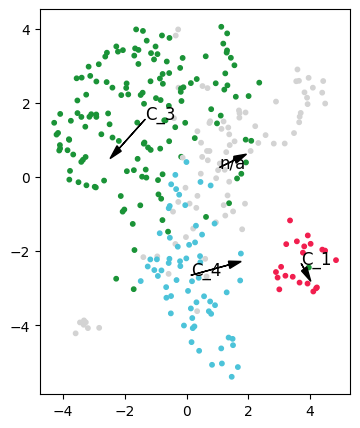

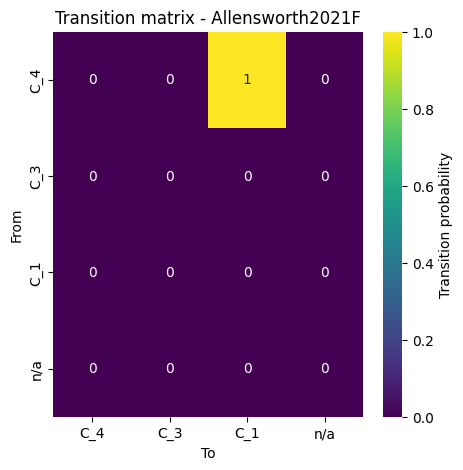

[0]


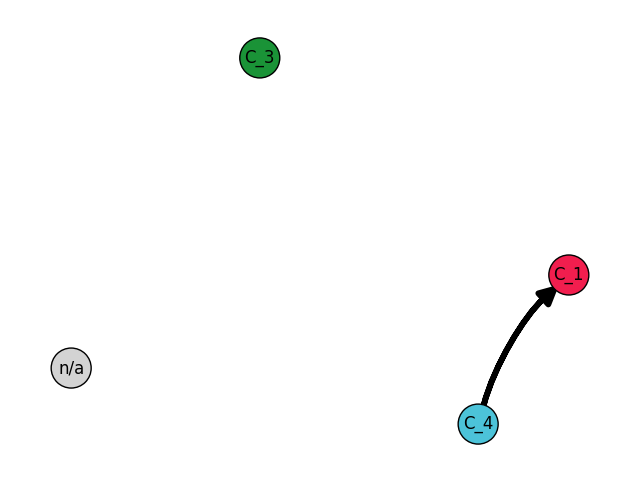

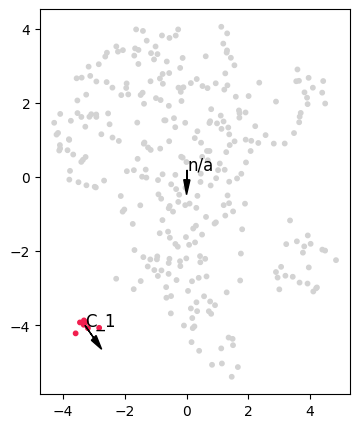

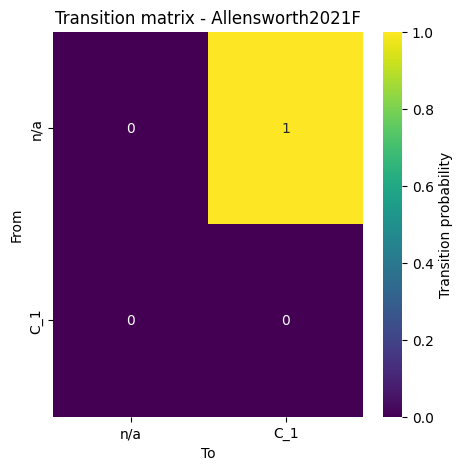

[0]


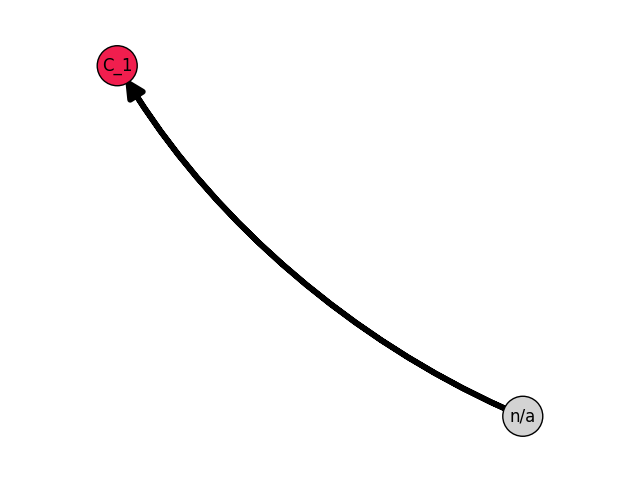

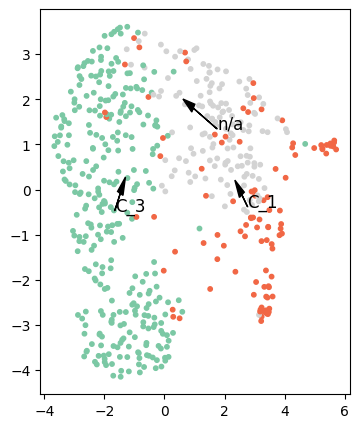

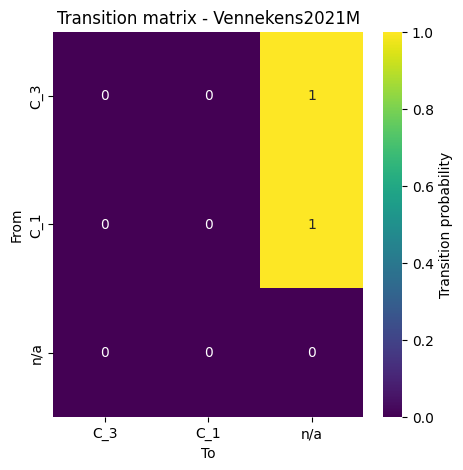

[0, 0]


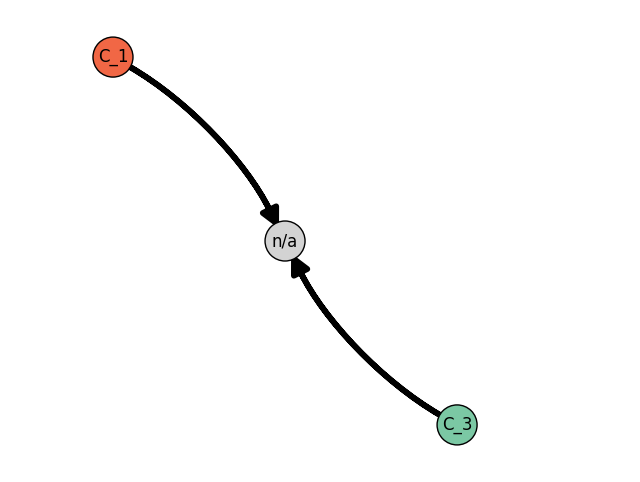

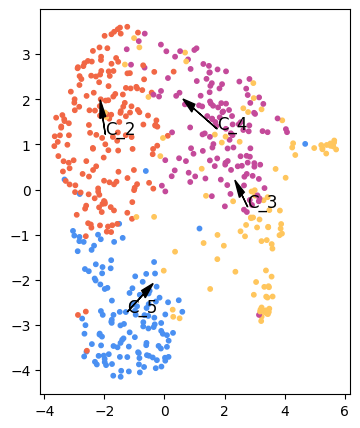

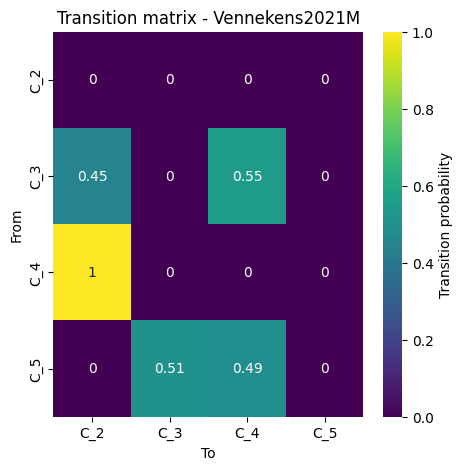

[140, 114, 0, 124, 130]


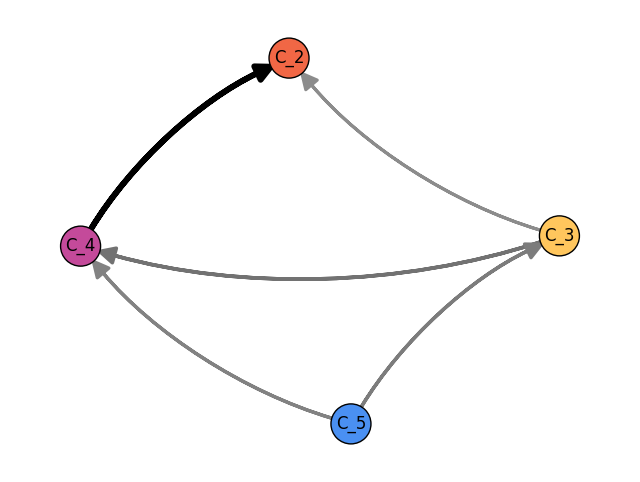

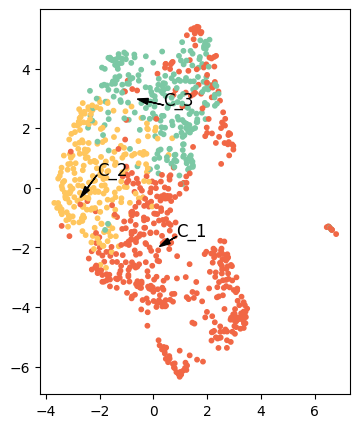

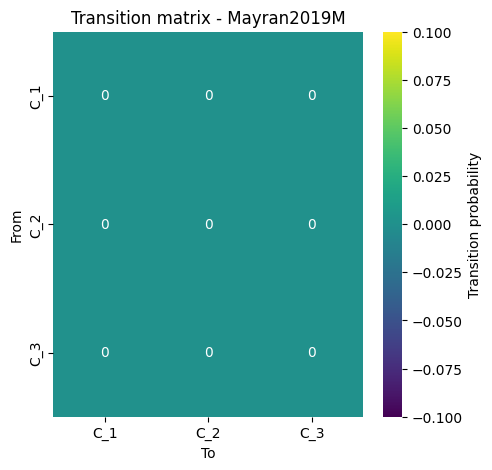

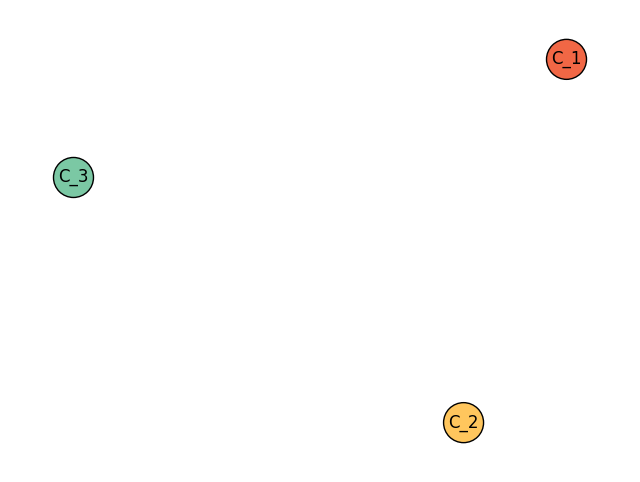

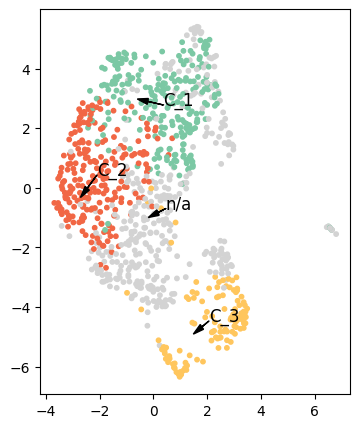

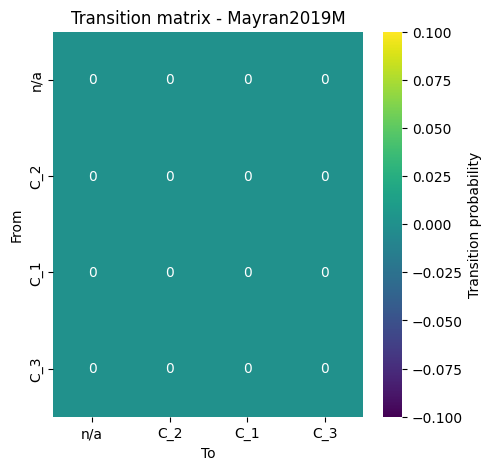

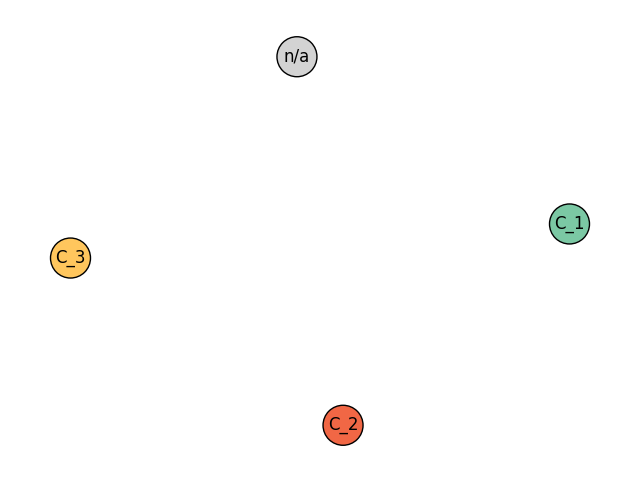

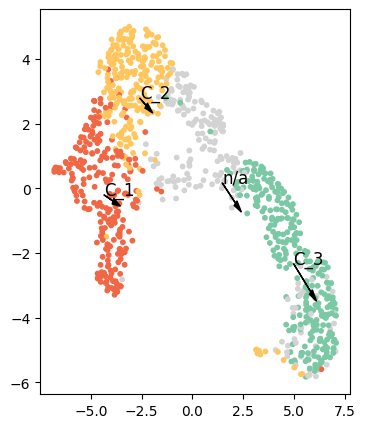

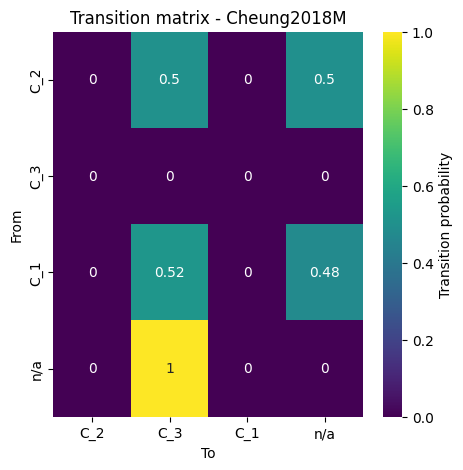

[127, 127, 121, 133, 0]


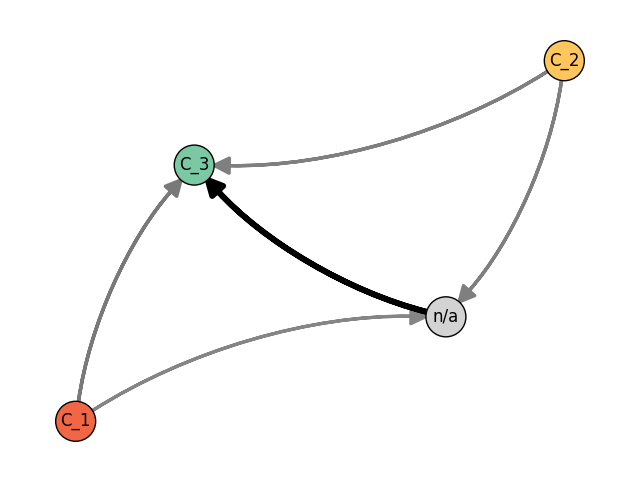

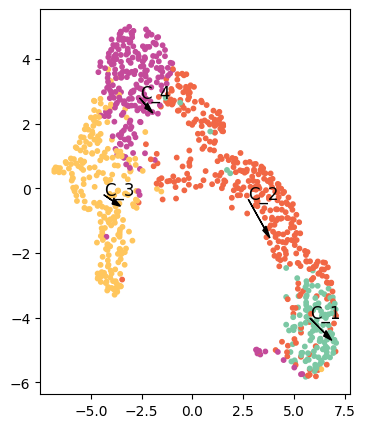

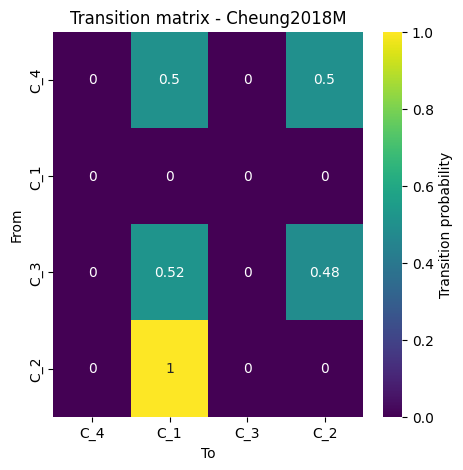

[127, 127, 122, 132, 0]


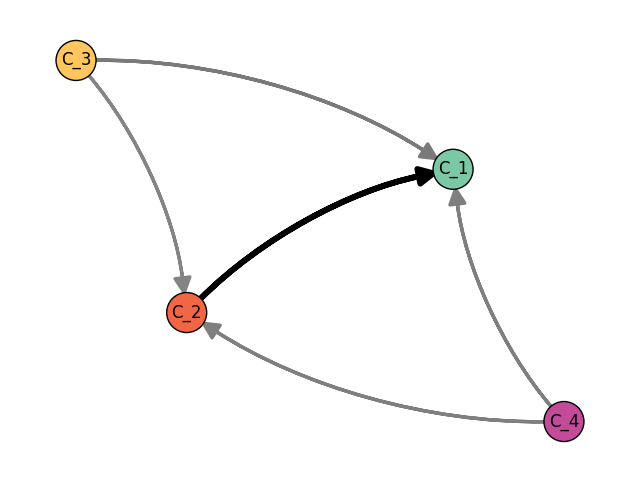

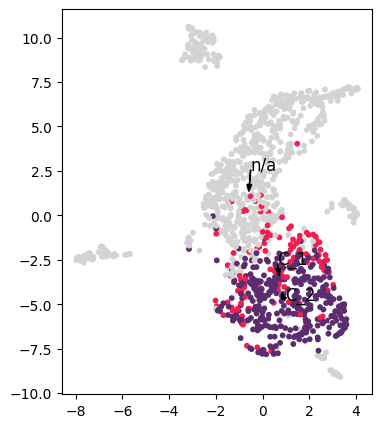

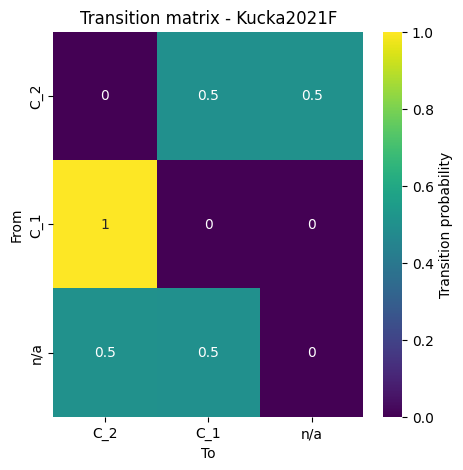

[127, 127, 0, 127, 127]


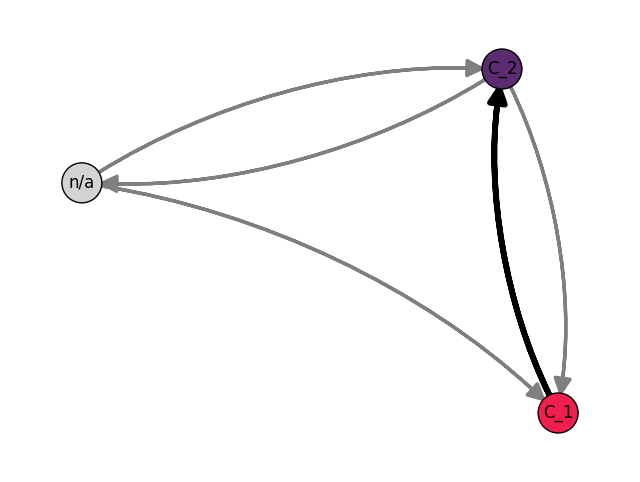

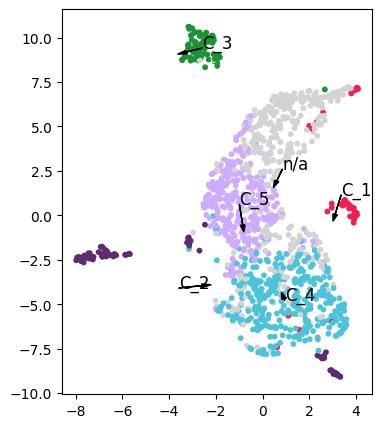

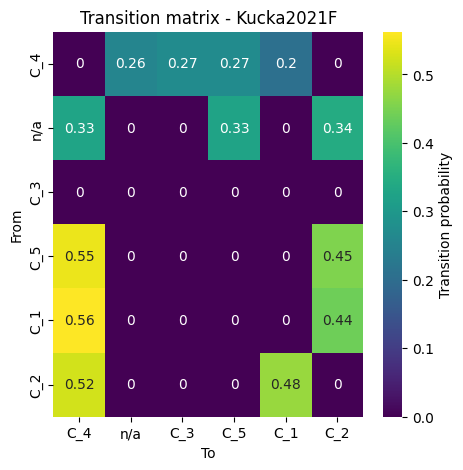

[138, 133, 132, 162, 105, 106, 98, 7, 49, 0, 56, 17, 39]


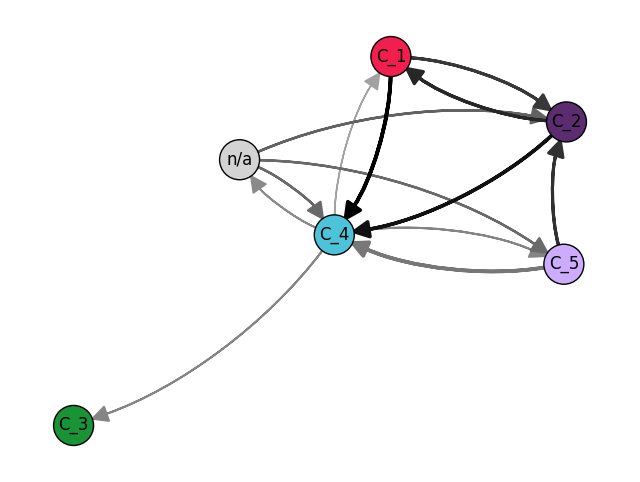

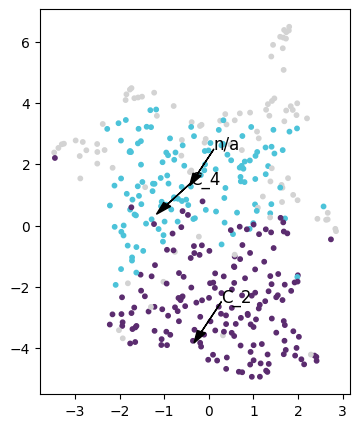

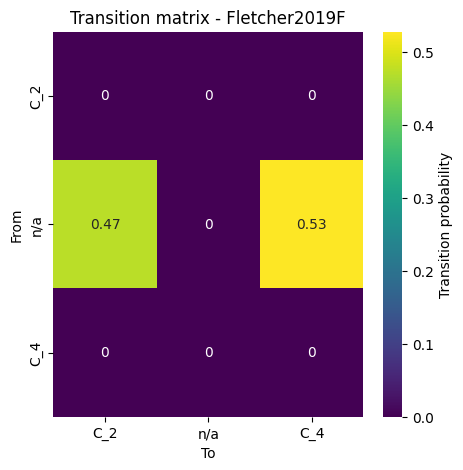

[26, 0]


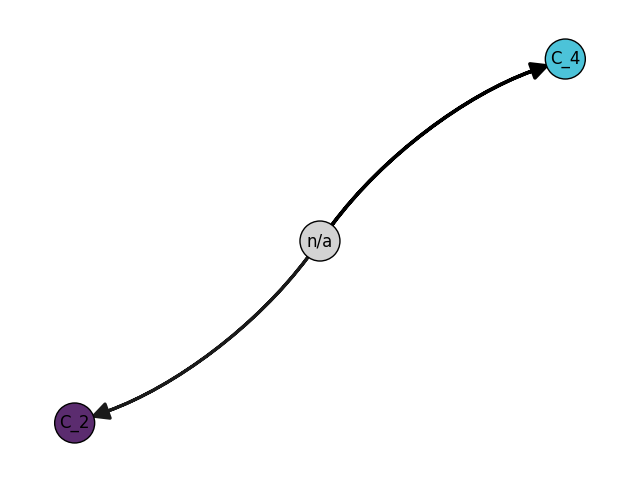

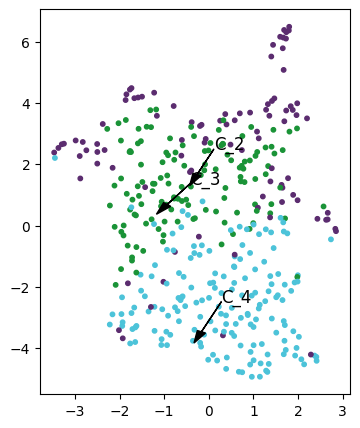

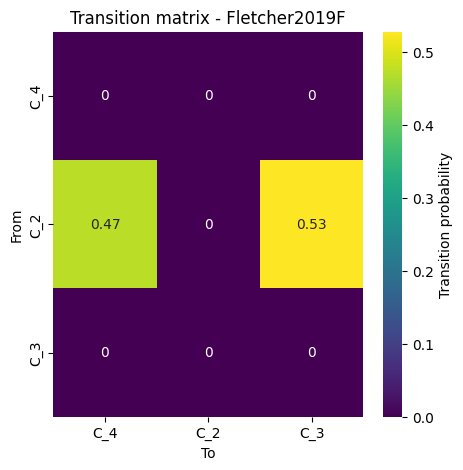

[26, 0]


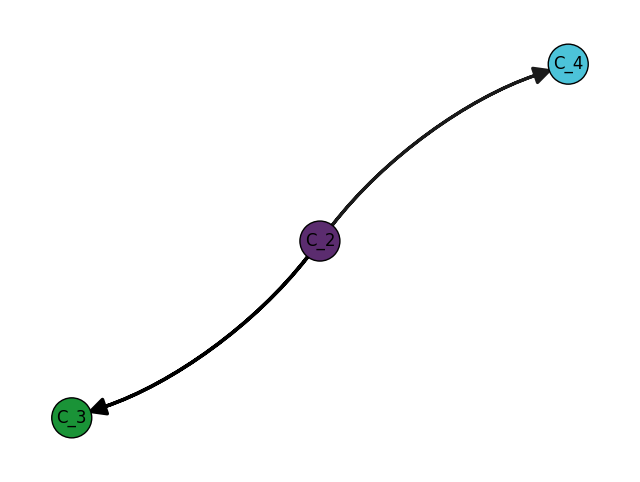

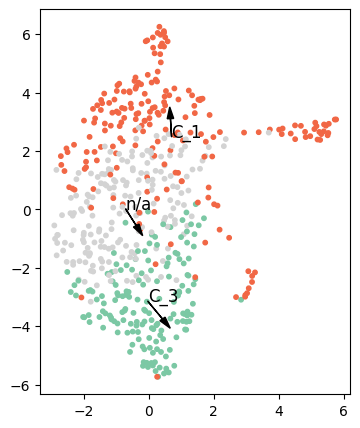

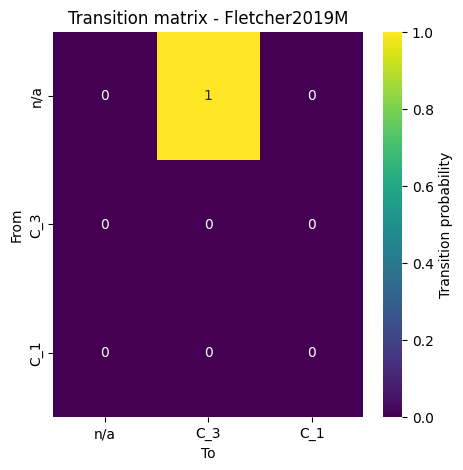

[0]


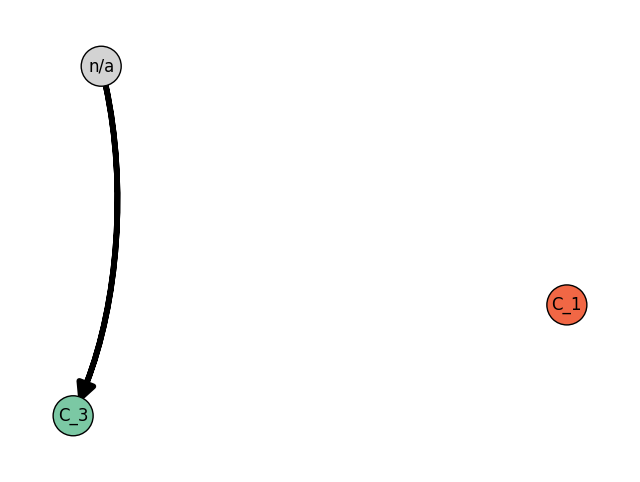

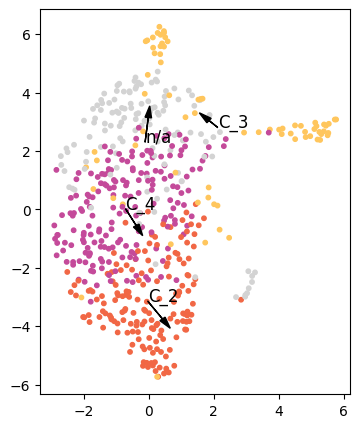

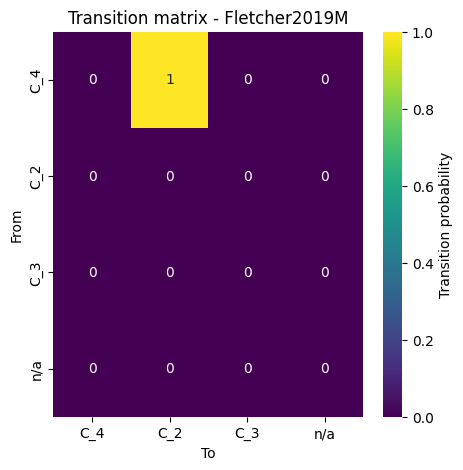

[0]


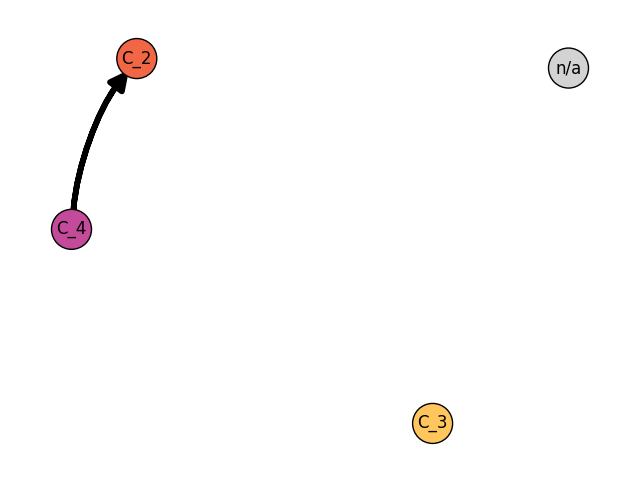

In [41]:
for d in datasets['study_id'].unique():
    calculate_transitions(d, comm_by="markers", do_plots=True)
    calculate_transitions(d, comm_by="nn", do_plots=True)

  0%|          | 0/4 [00:00<?, ?it/s]

[0, 127, 127, 0, 145, 125, 238]


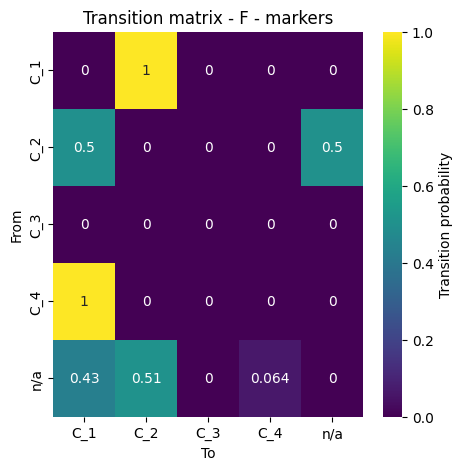

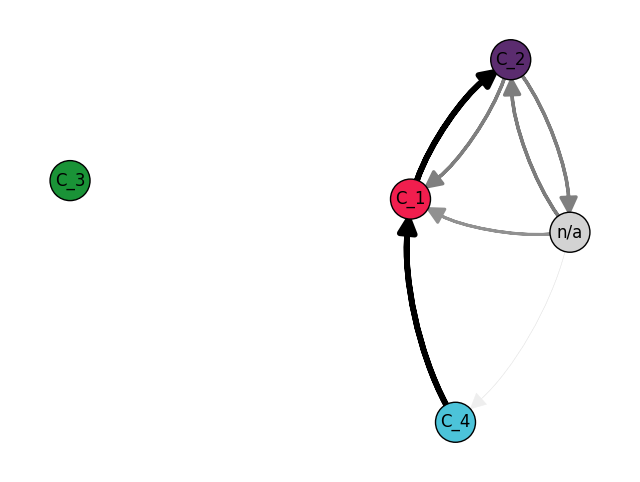

  0%|          | 0/6 [00:00<?, ?it/s]

[88, 166, 209, 145, 155, 0, 206, 48]


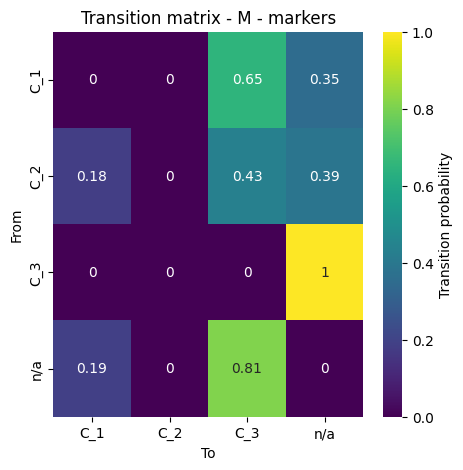

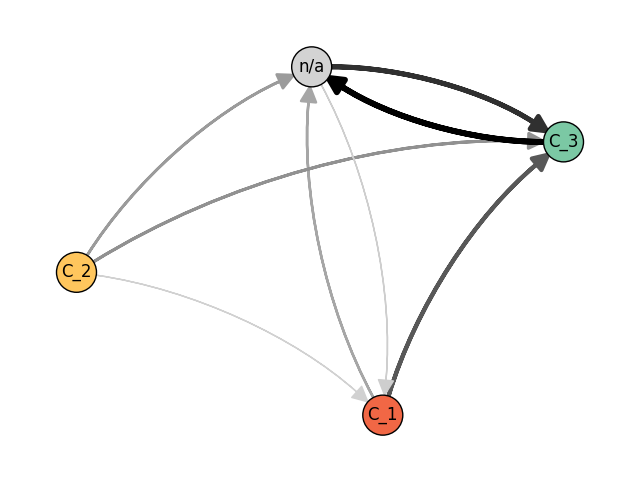

  0%|          | 0/4 [00:00<?, ?it/s]

[168, 143, 0, 91, 197, 23, 162, 133, 132, 138, 49, 7, 163, 130, 136, 137]


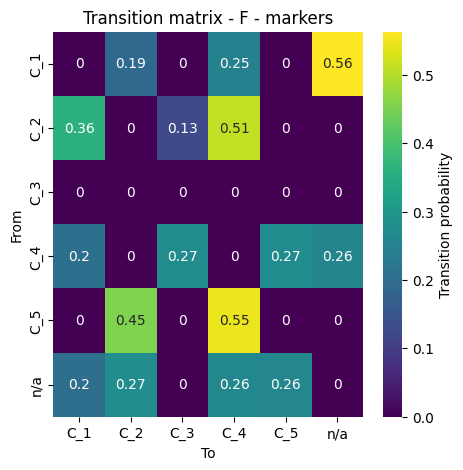

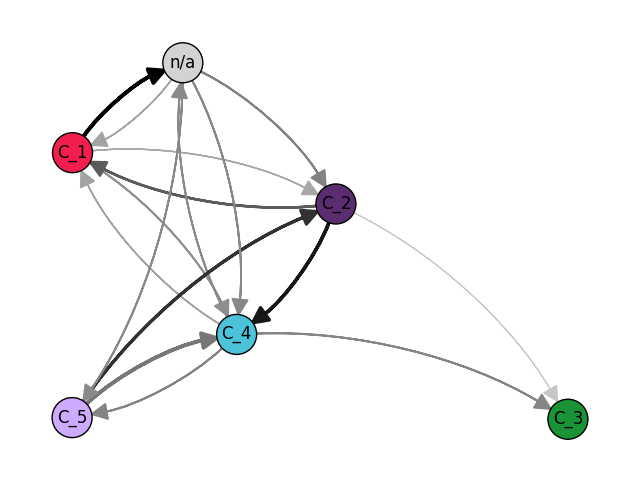

  0%|          | 0/6 [00:00<?, ?it/s]

[0, 216, 157, 116, 196, 154, 61, 105, 111, 167, 142, 161]


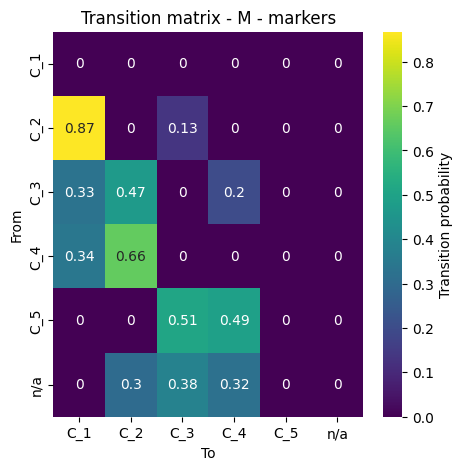

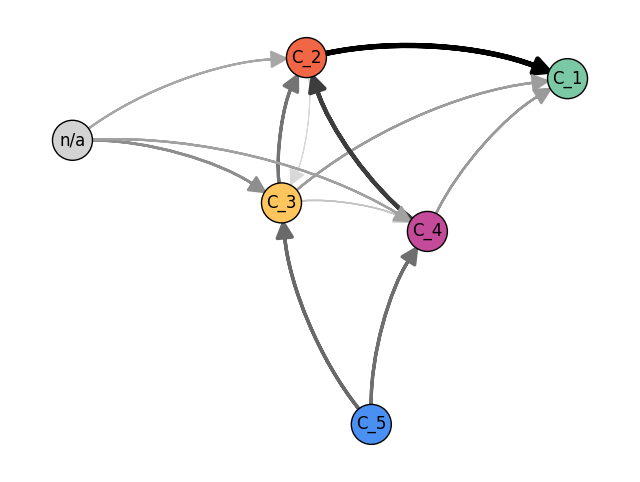

(array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.86766355, 0.        , 0.13233645, 0.        , 0.        ,
         0.        ],
        [0.33205543, 0.46961743, 0.        , 0.19832714, 0.        ,
         0.        ],
        [0.34238898, 0.65761102, 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.51028339, 0.48971661, 0.        ,
         0.        ],
        [0.        , 0.29826924, 0.38190528, 0.31982547, 0.        ,
         0.        ]]),
 array(['C_1', 'C_2', 'C_3', 'C_4', 'C_5', 'n/a'], dtype=object),
 None)

In [42]:
def get_merged_transition_graph(data_to_process:str = "M", comm_by:str = "markers", do_plot:bool = True, outfile:str = None) -> tuple[np.ndarray, list, ig.Graph]:
    """
    Calculates the merged transition matrix and graph for the datasets
    
    Parameters
    ----------
    data_to_process : str
        The data to process, either "M" or "F".
    comm_by : str
        The type of communities to use, either "markers" or "nn".
    do_plot : bool
        Whether to plot the graph, defaults to True.
    outfile : str
        The output file to save the plot to, defaults to None.
        
    Returns
    -------
    (summed_transition_matrix, all_communities_names, graph) : tuple
        summed_transition_matrix : np.ndarray
            The merged transition matrix between the communities.
        all_communities_names : list
            The list of all community names.
        graph : igraph.Graph
            The directed graph representing the transition matrix.
    """
    assert data_to_process in ["M", "F"]
    assert comm_by in ["markers", "nn"]
    
    transition_matrices = {}
    communities = {}
    graphs = {}

    filtered_datasets = datasets[datasets['study_id'].str.endswith(data_to_process)]
    filtered_datasets = filtered_datasets['study_id'].unique()

    for dataset in tqdm(filtered_datasets):
        transition_matrices[dataset], communities[dataset], graphs[dataset] = calculate_transitions(dataset, comm_by = comm_by, do_plots=False)

    num_cells = {dataset: vel_objects[dataset].shape[0] for dataset in filtered_datasets}
    
    weighted_transition_matrices = {dataset: pd.DataFrame(transition_matrices[dataset] * num_cells[dataset], 
                                                            columns=communities[dataset], index=communities[dataset]) for dataset in filtered_datasets}

    all_communities_names = np.unique(np.concatenate([c.categories for c in communities.values()]))
    # Now pad the transition matrices with zeros for missing communities
    for dataset in filtered_datasets:
        for c in all_communities_names:
            if c not in communities[dataset]:
                weighted_transition_matrices[dataset].loc[c] = 0
                weighted_transition_matrices[dataset][c] = 0

    # Sum all the weighted transition matrices
    summed_transition_matrix = np.zeros((len(all_communities_names), len(all_communities_names)))
    for dataset in filtered_datasets:
        summed_transition_matrix += weighted_transition_matrices[dataset].reindex(index=all_communities_names, columns=all_communities_names).fillna(0).values
    
    # Normalise the transition matrix
    summed_transition_matrix = summed_transition_matrix / summed_transition_matrix.sum(axis=1)[:, None]
    summed_transition_matrix = np.nan_to_num(summed_transition_matrix)
        
    if do_plot:
        plt.figure(figsize=(5, 5))
        sns.heatmap(summed_transition_matrix, annot=True, 
                    xticklabels=all_communities_names, yticklabels=all_communities_names,
                    cmap='viridis', cbar_kws={'label': 'Transition probability'})
        plt.xlabel("To")
        plt.ylabel("From")
        plt.title(f"Transition matrix - {data_to_process} - markers")
        if outfile:
            plt.savefig(outfile)

    if data_to_process == "M":
        if comm_by == "markers":
            community_palette = community_palette_markers_M
        else:
            community_palette = community_palette_lab_tr_M
    else:
        if comm_by == "markers":
            community_palette = community_palette_markers_F
        else:
            community_palette = community_palette_lab_tr_F
            
    graph = create_graph(summed_transition_matrix, all_communities_names, palette = community_palette, do_plot=do_plot, outfile= outfile)
    
    return summed_transition_matrix, all_communities_names, graph

get_merged_transition_graph(data_to_process="F", comm_by="markers", outfile = f"{output_dir}merged_transition_matrix_F_markers.pdf")
get_merged_transition_graph(data_to_process="M", comm_by="markers", outfile = f"{output_dir}merged_transition_matrix_M_markers.pdf")
get_merged_transition_graph(data_to_process="F", comm_by="nn", outfile = f"{output_dir}merged_transition_matrix_F_nn.pdf")
get_merged_transition_graph(data_to_process="M", comm_by="nn", outfile = f"{output_dir}merged_transition_matrix_M_nn.pdf")